In [38]:
#@Author : dipu
#date : 19Nov2020
#project : GPB portfolio

In [39]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import load_model
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [40]:
look_back = 40
forward_days = 10
num_periods = 20

In [41]:
start = dt.datetime(2013,1,1)
end = dt.datetime(2020,10,19)
stk_data = gh(symbol='SBIN',start=start,end=end)

In [42]:
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']
#train_stock_price = data2.iloc[:, 1:2].values

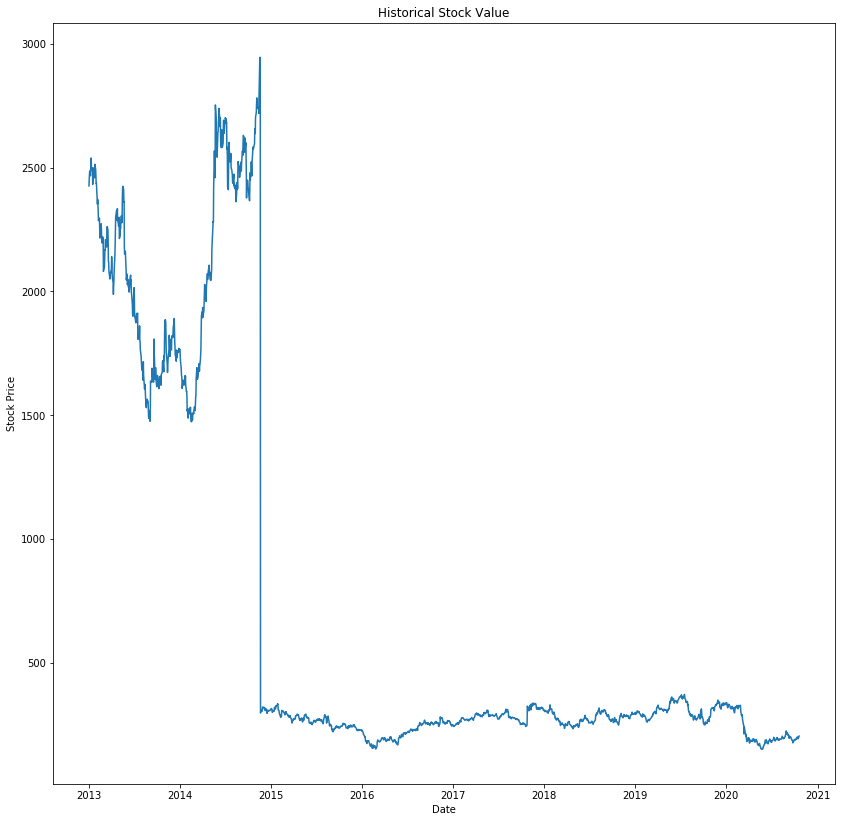

In [43]:
df = data2['Close']
plt.figure(figsize=(14,14))
plt.plot(df)
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [44]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[2426.45],
       [2450.55],
       [2471.6 ],
       [2486.7 ],
       [2467.6 ]])

In [45]:
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.81419729],
       [0.82282014],
       [0.83035171],
       [0.83575441],
       [0.82892053]])

In [46]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [47]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [48]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [49]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1344, 40, 1)
(336, 40, 1)
(20, 40, 1)
(1344, 10)
(336, 10)
(20, 10)


In [50]:
NUM_NEURONS = 50
NUM_NEURONS_Second = 30
EPOCHS = 15

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS,input_shape=(look_back,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(NUM_NEURONS,input_shape=(look_back,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(NUM_NEURONS_Second,input_shape=(NUM_NEURONS,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=16)

Train on 1344 samples, validate on 336 samples
Epoch 1/15
1344/1344 [==============================] - 14s 10ms/step - loss: 0.0214 - val_loss: 0.0097
Epoch 2/15
1344/1344 [==============================] - 8s 6ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 3/15
1344/1344 [==============================] - 8s 6ms/step - loss: 0.0055 - val_loss: 0.0080
Epoch 4/15
1344/1344 [==============================] - 8s 6ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 5/15
1344/1344 [==============================] - 7s 6ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 6/15
1344/1344 [==============================] - 7s 5ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 7/15
1344/1344 [==============================] - 7s 5ms/step - loss: 0.0046 - val_loss: 0.0075
Epoch 8/15
1344/1344 [==============================] - 8s 6ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 9/15
1344/1344 [==============================] - 7s 6ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 10/15
1344/1344 [==========

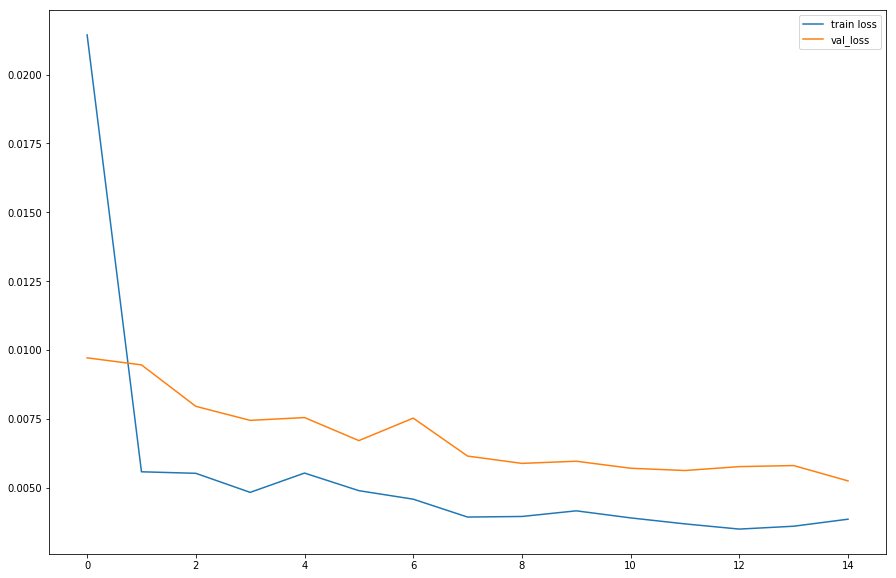

In [51]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [52]:
#Saving the model
file_name = 'HFDC_10days_lookahead_RNN.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `HFDC_10days_lookahead_RNN.h5` to disk


In [53]:
Xt = model.predict(X_test)

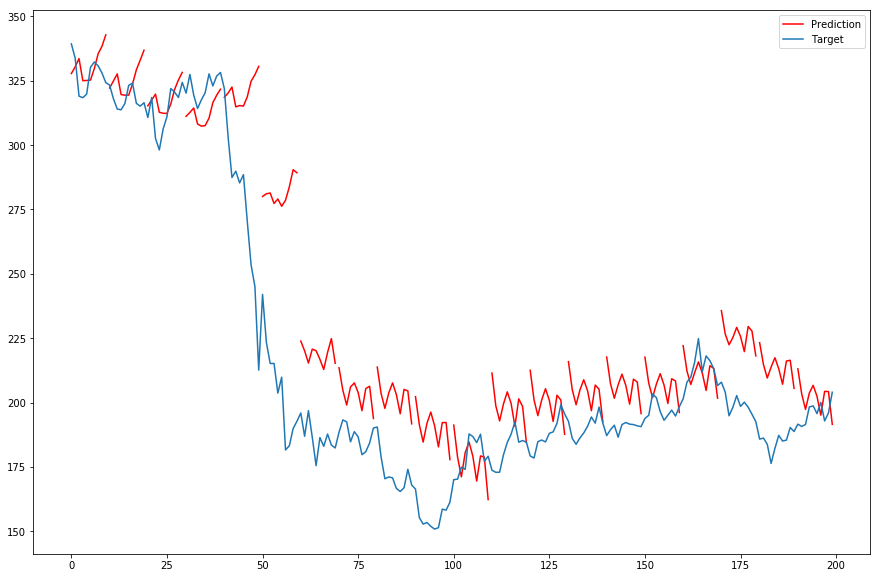

In [54]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

In [55]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [56]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [57]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [58]:
y = np.concatenate((ytrain, ytest), axis=0)

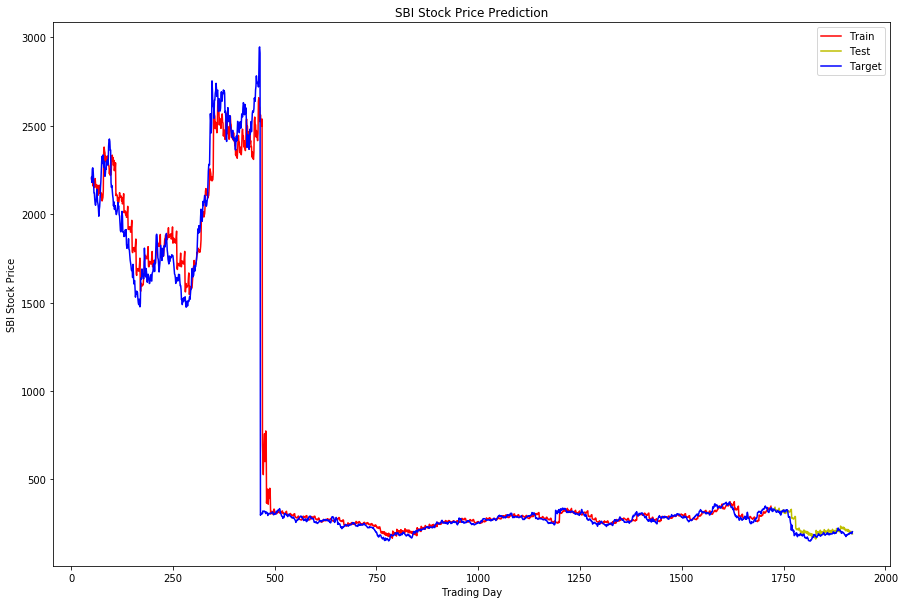

In [61]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()

#plt.legend(loc='best')
plt.show()